In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data
from ptycho_functions import RAAR_loop, mPIE_loop,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, get_simulated_data, plot_guess_and_model

/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscCdi-0.4.0-py3.6-linux-ppc64le.egg/sscCdi
to be done!
/home/ABTLUS/yuri.tonin/.local/lib/python3.6/site-packages/sscRaft/lib/libraft.cpython-36m-powerpc64le-linux-gnu.so


## Phantom

Created complex sinogram of shape (1, 120, 120) from object of size (120, 120, 120)
	Data saved at /home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/complex_phantom/model/complex_sinogram.npy
Loading probe of type -CAT- with shape (50, 50)
Creating dataset 1/1
Calculating diffraction data for object of size (140, 140). Used 10 pixel of offset at the border.
	Data saved at:  /home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/complex_phantom/model/model_obj.npy
Detector data created with shape (64, 50, 50)


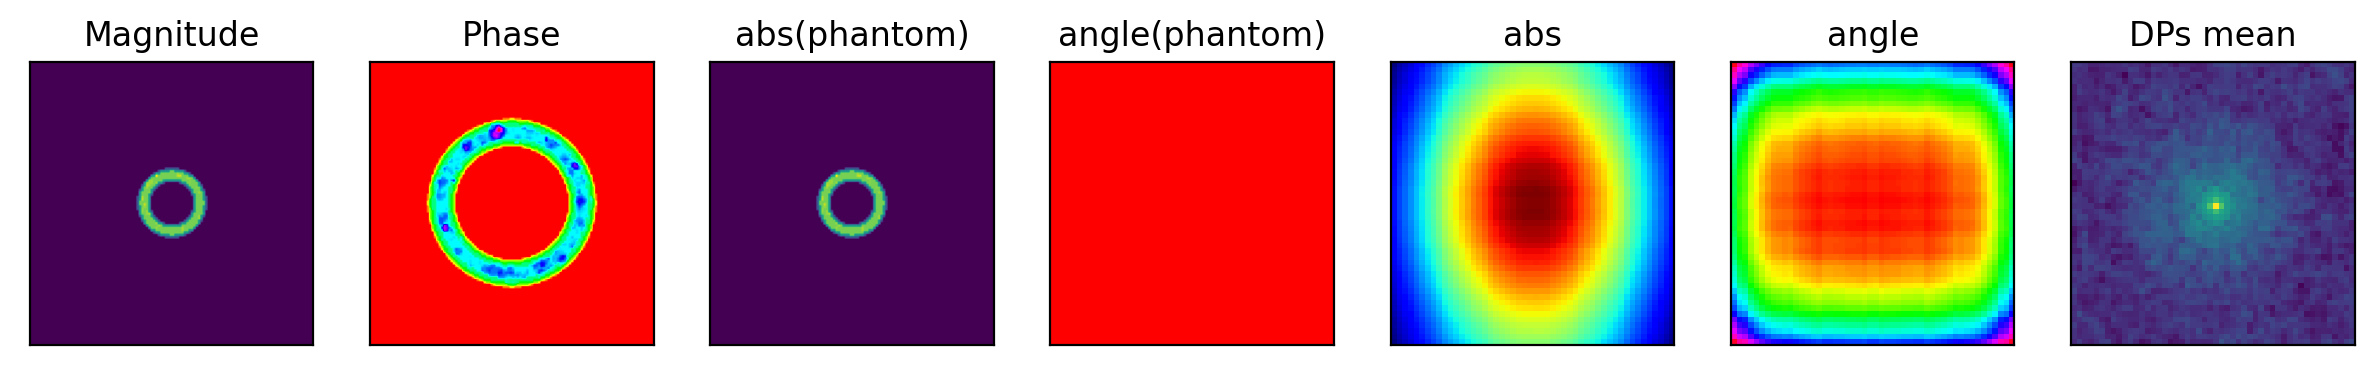

Phantom created at /home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/complex_phantom/


In [2]:
inputs = {
"path" : "/home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 120, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 6, #keV
"distance": 1, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [10,10], # pixels
"n_of_angles": 0
}

offset = 10
phantom, magnitude, phase, sinogram, probe, data = create_ptycho_phantom(inputs,sample="donut",probe_type="CAT",offset=offset,position_errors=False,load=False,preview=True) # run with load = False first; this will create data; then you can run with load = True 

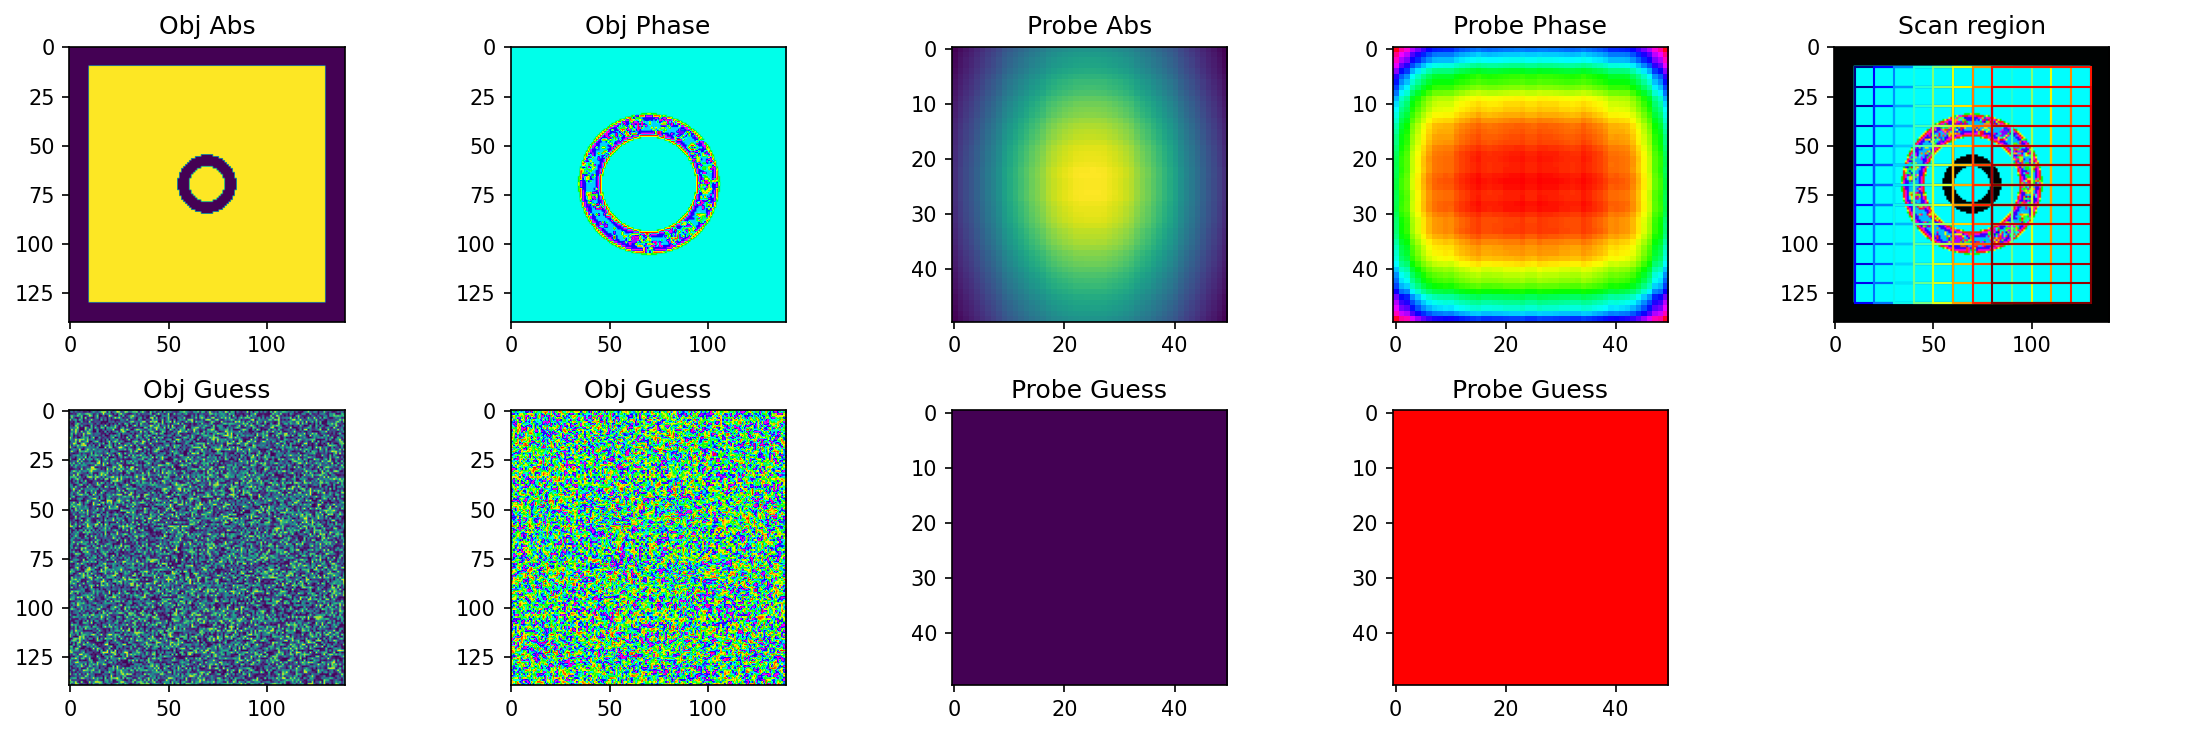

In [3]:
if 0: # dummy sample
    diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=True,add_position_errors=False)
    """ Experiment Parameters """
    c_speed = 299792458        # Velocity of Light [m/s]
    planck  = 4.135667662E-18  # Plank constant [keV*s]
    position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
    distance = 30  # meters
    energy = 10    # keV
    n_pixels = 3072
    pixel_size = 55.13e-6  # meters
    wavelength = c_speed * planck / energy
    dx = wavelength*distance/(n_pixels*pixel_size)
    oversampling_ratio = wavelength*distance/(position_step*pixel_size)
    print('Object pixel size:',dx)
    print("Oversampling: ",oversampling_ratio)
    experiment_params = dx, wavelength,distance
    probe_guess = model_probe*np.exp(-1j*model_probe*2)  
    probe_guess = np.ones_like(probe_guess) 
    obj_guess = np.ones_like(model_obj) # constant object
    obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j
    
else: # complex phantom
    data_folder = "/home/ABTLUS/yuri.tonin/00000000/data/ptycho3d/"
    dataname = "complex_phantom"
        
    diffraction_patterns, positions, model_obj, model_probe, obj_pixel_size, wavelength,distance = load_data(data_folder,dataname,offset)
    experiment_params = obj_pixel_size, wavelength,distance
    
    """ Initial guesses """
    object_shape = set_object_size_pxls( positions[:,0], positions[:,1],model_probe.shape,border=offset)
    obj_guess = np.random.rand(object_shape[0],object_shape[1])+1j
    # probe_guess = model_probe
    probe_guess = np.ones(diffraction_patterns[0].shape)
    

iterations = 150
n_of_modes = 3

plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions)

In [4]:
if 1: 
    """ RAAR """
    beta = 0.995
    epsilon = 0.01
    RAAR_params = (beta,epsilon)
    RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

Starting RAAR...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150


In [5]:
if 1: 
    """ mPIE """
    if 0: # suggested min from paper
        regularization_object, regularization_probe = 0.05, 0.5
        step_object, step_probe = 0.1, 0.2
        friction_object, friction_probe = 0.5, 0.75
        momentum_counter = 10
    elif 1: # suggested max from paper
        regularization_object, regularization_probe = 0.25, 5
        step_object, step_probe = 0.5, 1
        friction_object, friction_probe = 0.9, 0.99
        momentum_counter = 100
    else: # my params
        regularization_object, regularization_probe = 0.01,0.01
        step_object, step_probe = 0.99, 0.99
        friction_object, friction_probe = 0.9, 0.9
        momentum_counter = 100 

    mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
    PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE_loop(diffraction_patterns, positions,obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj)

Starting PIE...
	Iteration 0/150
	Iteration 50/150
	Iteration 100/150


In [6]:
if 0:
    """ multiprobe RAAR """
    RAAR_params = (beta,epsilon)
    RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
    RAAR2_probe = RAAR2_probes[0]
RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time  = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time    
    
if 0:
    """ multiprobe mPIE """
    mPIE_params = {}
    mPIE_params["regularization_object"] = regularization_object
    mPIE_params["regularization_probe"]  = regularization_probe
    mPIE_params["step_object"]           = step_object
    mPIE_params["step_probe"]            = step_probe
    mPIE_params["friction_object"]       = friction_object
    mPIE_params["friction_probe"]        = friction_probe
    mPIE_params["momentum_counter"]      = momentum_counter
    PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
    PIE2_obj = PIE2_obj[0]
    PIE2_probe = PIE2_multiprobe[0]
PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = PIE_obj, PIE_probe, PIE_error, PIE_time

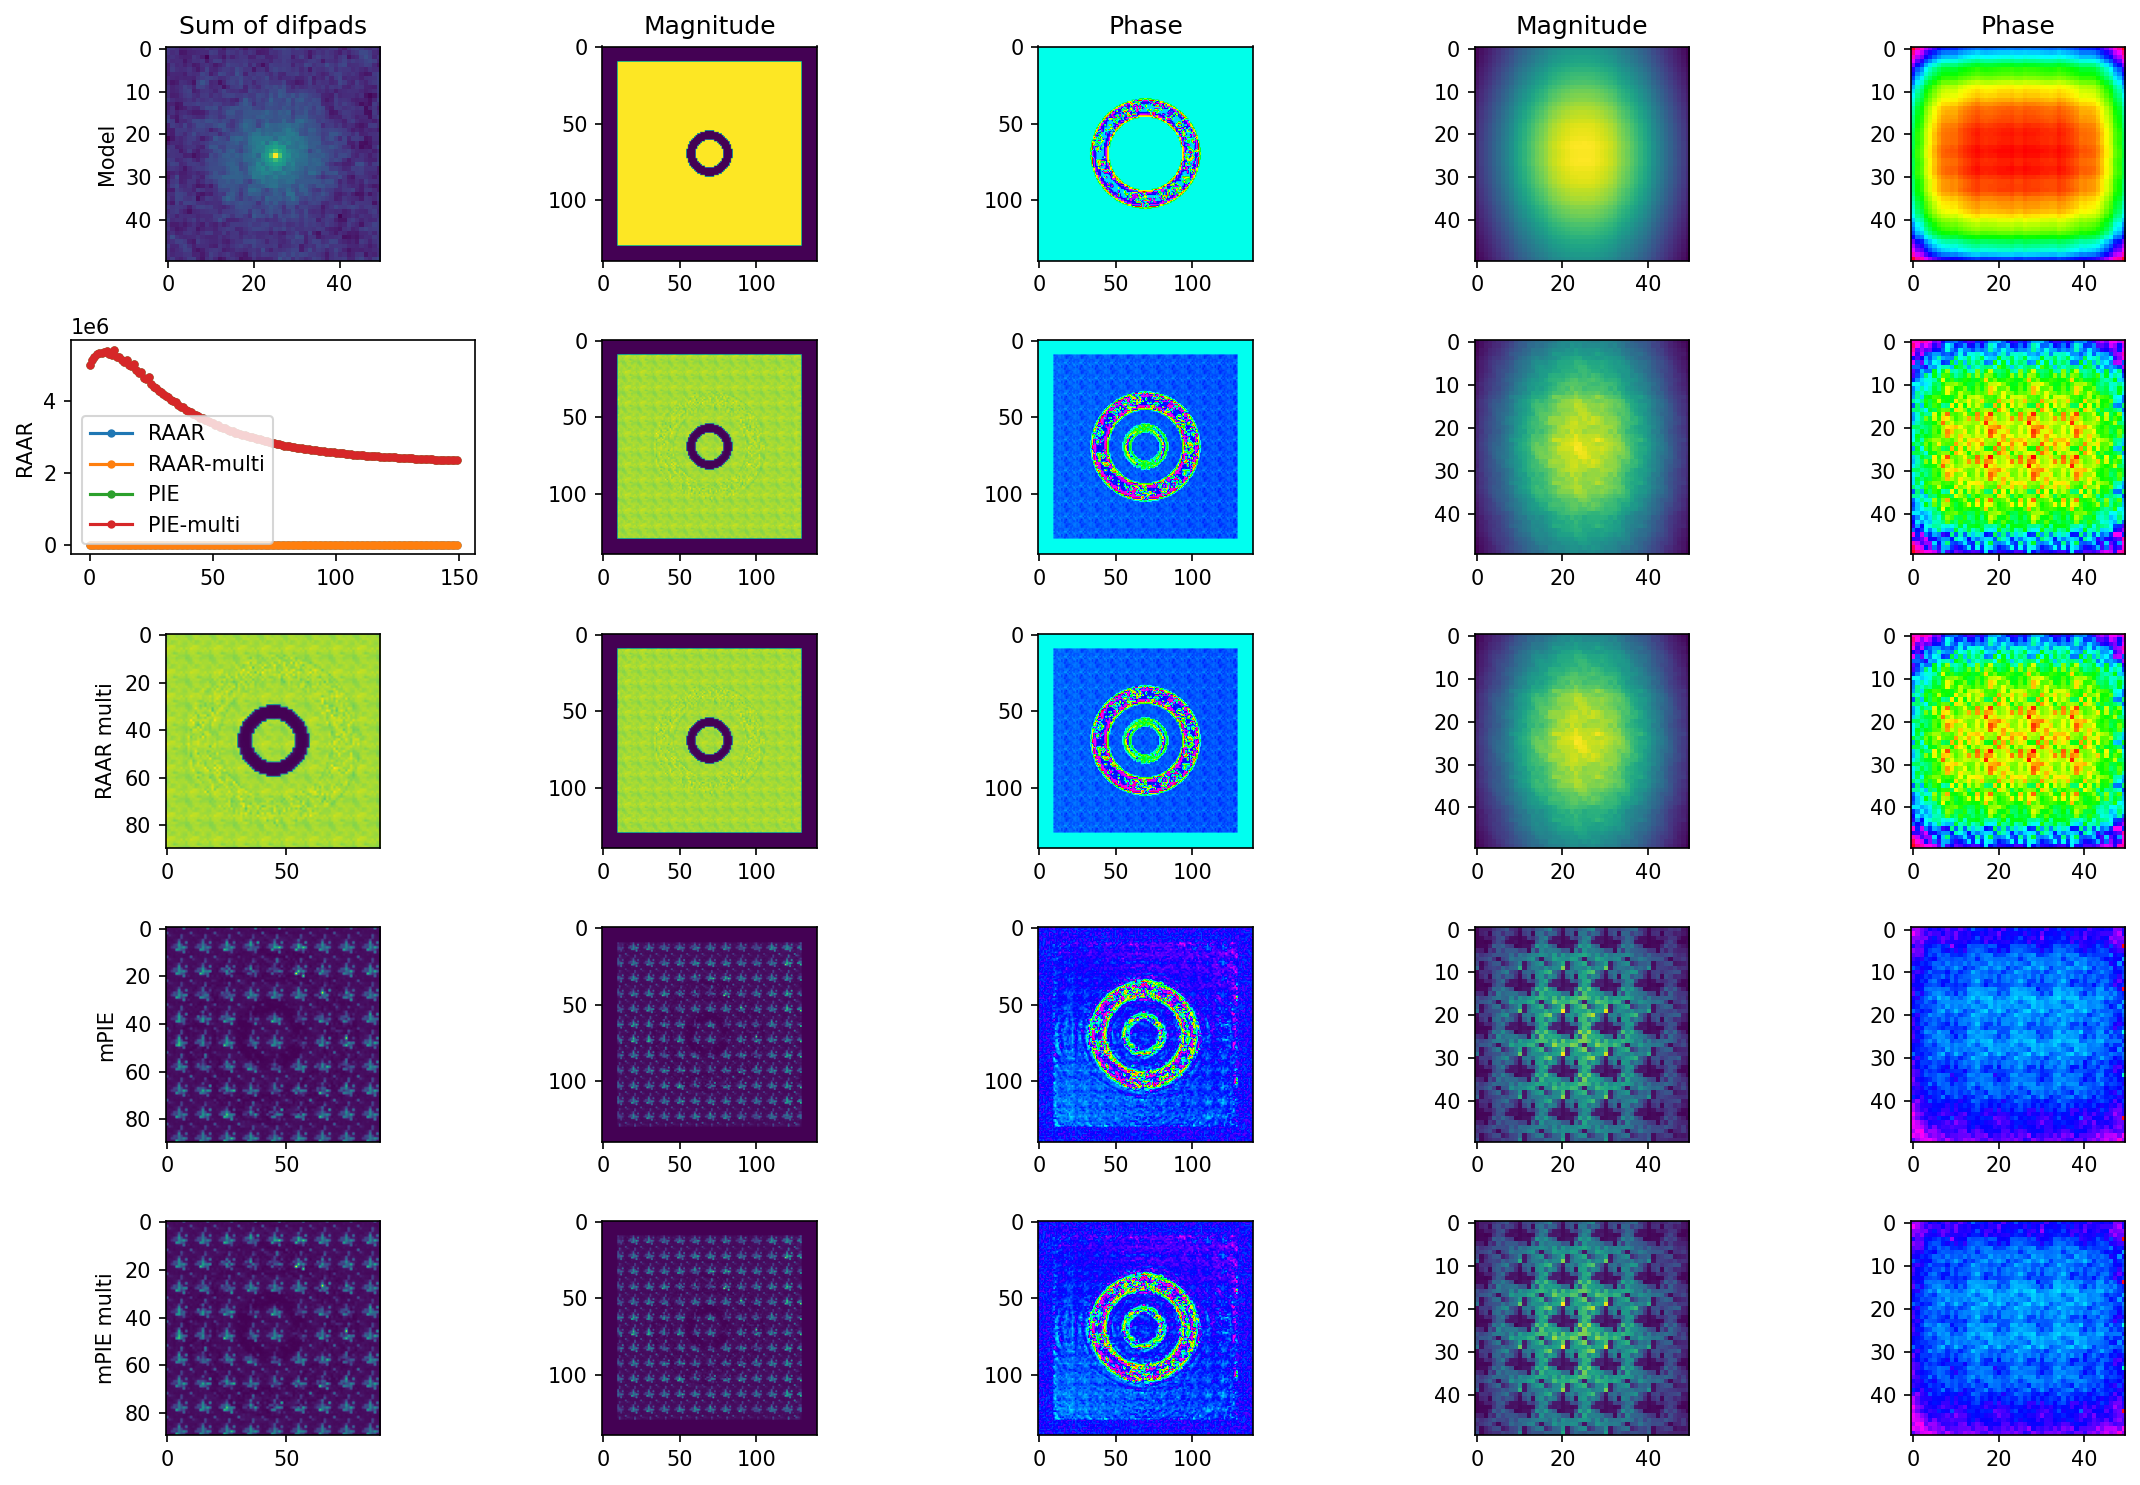

In [7]:
plot_results3(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )
# plot_probe_modes(RAAR2_probes)
# plot_probe_modes(PIE2_multiprobe)''